In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from scipy.integrate import quad,dblquad,nquad
from scipy.optimize import root_scalar
from timeit import default_timer as timer
import vegas
#import jax.numpy as jnp
#from jax import grad

In [2]:
# Global constants
# light speed, cm
c = 2.99792458e10
# kpc to cm
kpc2cm = 3.08567758e21
# erg to MeV
erg2MeV = 624150.913
# year in seconds
yr = 31536000
# Neutrino lumonisity, single specie
Lv = 3e52/6

## SN neutrino and DM halo profile
The neutrino number density per energy
$$
\frac{dn_\nu}{dE_\nu}(r,E_\nu) = \sum_\beta \frac{L_{\nu_{\beta}}}{4\pi r^2 c \langle E_{\nu_\beta}\rangle}f_{\nu_\beta}(E_{\nu_\beta})
$$
where $\beta$ indicates the neutrino flavor and
$$
f_{\nu_\beta}(E_{\nu_\beta}) = \frac{1}{F_2(\eta_\nu)}\frac{1}{T_{\nu_\beta}^3}\frac{E_{\nu_\beta}^2}{\exp(E_{\nu_\beta}/T_{\nu_\beta} -\eta_\nu)+1}
$$
and in general $\eta_\nu=3$ for all flavor $\beta$ and $F_2(\eta_\nu)\approx 18.96$.

NFW DM density profile
$$
n_\chi(r)=\frac{\rho_\chi}{m_\chi}\frac{1}{\frac{r}{r_s}(1+\frac{r}{r_s})^2}
$$
where $\rho_\chi = 184\,{\rm MeV/cm}^3$ and $r_s=24.42\,{\rm kpc}$.

In [3]:
def dnv(r,Ev,Lv=Lv):
    """
    Neutrino number density per energy at r
    
    Input
    ------
    Enu: Neutrino energy in MeV
    r: Distance to the SN explosion site, in cm
    Lv: Neutrino luminosity, default is 1e52 erg/s, total time is 10 second
    
    Output
    ------
    Neutrino flux at r: # per Enu per cm**3 per second
    """
    Lv = Lv*erg2MeV
    #r = r*kpc2cm
    
    def _fv(Ev,Tv):
        """
        Fermi-Dirac distribution
        """
        exponent = Ev/Tv - 3
        if exponent <= 709.782:
            return (1/18.9686)*Tv**(-3)*(Ev**2/(np.exp(exponent)+1))
        else:
            return 0
    
    nue_dist = _fv(Ev,2.76)/11
    nueb_dist = _fv(Ev,4.01)/16
    # total 4 species for x
    nux_dist = _fv(Ev,6.26)/25
    
    L=Lv/(4*np.pi*r**2*c)
    return L*(nue_dist+nueb_dist+4*nux_dist)


def nx(r,mx,rho=184,rs=24.42):
    """
    DM number density at r
    
    Input
    ------
    r: distance to GC, in cm
    mx: DM mass in MeV
    rho: characteristic density, default is 184 MeV/cm^3
    rs: characteristic length, default is 24.42 kpc
    
    Output
    ------
    DM number density, #/cm^3 at r
    """
    rr=r/rs/kpc2cm
    return (rho/mx)/(rr*(1+rr)**2)

## DM emissivity

Upscattered DM emissivity
$$
j_\chi^N(r,p_\chi,\alpha)=\frac{dn_\chi}{dtdp_\chi d\Omega_\alpha}=\frac{dn_\chi}{dtdE_\nu d\Omega_\alpha}\frac{dE_\nu}{dp_\chi}=c\sigma_{\chi \nu}n_\chi(r)\frac{dn_\nu}{dE_\nu}g(\alpha,E_\nu)\frac{dE_\nu}{dp_\chi},
$$
where $g(\alpha,E_\nu)$ is the angular distribution of the upscattered DM, $p$ the upscattered DM momentum and $\alpha$ the scattering angle.

The angluar distribution is given by
$$
g(\alpha,E_\nu)=\frac{dn_\chi}{d\Omega_\alpha}=\frac{\sin[2\tan^{-1}(\gamma \tan\alpha)]}{2\pi \sin\alpha}\frac{\gamma \sec^2\alpha}{1+\gamma^2\tan^2\alpha}=\frac{\gamma^2}{\pi}\frac{\sec^3\alpha}{(1+\gamma^2\tan^2\alpha)^2} = \frac{\gamma^2}{\pi}\frac{r^3\sqrt{r^2-R^2\sin^2\theta}}{(r^2+R^2(\gamma^2-1)\sin^2\theta)^2}
$$
and satisfies the normalization condiation
$$
\int g(\alpha,E_\nu)d\cos\alpha d\phi =1
$$
where $\alpha$ runs from $0$ to $\pi/2$ and $\gamma=E_\chi/m_\chi$. As a matter of fact, the above condition is irrelevant to $\gamma$.

### Find $E_\nu$ with given $T_\chi$ and $\alpha$

We re-express $p_\chi$ in terms of kinetic energy $T_\chi$ via
$$
p_\chi = \sqrt{T_\chi(T_\chi+2m_\chi)}\to dp_\chi = \frac{T_\chi + m_\chi}{\sqrt{T_\chi(T_\chi+2m_\chi)}}dT_\chi \equiv \frac{dT_\chi}{v_\chi(T_\chi,m_\chi)}
$$
thus
$$
\frac{dE_\nu}{dp_\chi}= v_\chi(T_\chi,m_\chi)\frac{dE_\nu}{dT_\chi}\quad {\rm and}\quad \frac{dE_\nu}{dp_\chi}dp_\chi=\frac{dE_\nu}{dT_\chi}dT_\chi.
$$
In the limits of non-relativistic $T_\chi \ll m_\chi$ and of relativistic $T_\chi \gg m_\chi$, they have $v_\chi\to \sqrt{2T_\chi/m_\chi}$ and $v_\chi \to 1$ respectively as expected. Note that the relation between $E_\nu$ and $T_\chi$ can be determined by
$$
T_\chi = \frac{E_\nu^2}{E_\nu+m_\chi/2}\left(\frac{1+\cos\theta_c}{2}\right)
$$
and
$$
\theta_c = 2\tan^{-1}(\gamma \tan\alpha)
$$
where $\gamma = E_{\chi,{\rm cm}}/m_\chi$. Once $\alpha$ and $T_\chi$ are given, $E_\nu$ will be specified, hence numerically we have
$$
\frac{dE_\nu}{dT_\chi} =\underset{dT_{\chi}\to 0}{\lim} \frac{E_\nu(T_\chi+dT_\chi,\alpha)-E_\nu(T_\chi,\alpha)}{dT_\chi}.
$$
We can obtain $E_\nu$ with given $T_\chi$ and $\alpha$ through *root finding method*.

An alternative way is to derive the *analytical expression* of $E_\nu$ in terms of $T_\chi$,
$$
E_{\nu}=\frac{T_{\chi}\sec^{2}\alpha+\sec\alpha\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}}{2-T_{\chi}\tan^{2}\alpha/m_{\chi}}=\frac{T_{\chi}m_{\chi}}{\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})\left(1-\frac{R^{2}}{r^{2}}\sin^{2}\theta\right)}-T_{\chi}}
$$
where $\gamma$ can be expressed in terms fo $E_\nu$ and $m_\chi$ by
$$
\gamma=\frac{E_{\chi,{\rm cm}}}{m_\chi}=\frac{s+m_\chi^2}{2\sqrt{s}}\frac{1}{m_\chi}=\frac{E_\nu +m_\chi}{\sqrt{m_\chi(2E_\nu + m_\chi)}}.
$$
It is obvious that the numerator of $E_\nu$ is always positive but the denominator is not when $2<T_\chi \tan^2\alpha/m_\chi$. Thus $E_\nu$ will turn negative and becomes unphysical. For the given $\alpha$ and $m_\chi$, the allowed range is $T_\chi < 2m_\chi/\tan^2\alpha$. There is another root for $E_\nu$ but it is always negative.

Thus we have the differential
$$
\frac{dE_\nu}{dT_\chi}= \frac{m_{\chi}^{2}\sec\alpha(2\sec\alpha\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}+2m_{\chi}+T_{\chi}\sec^{2}\alpha+T_{\chi})}{(T_{\chi}\tan^{2}\alpha-2m_{\chi})^2\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}}=\frac{m_{\chi}^{2}\left(\frac{2\sqrt{T_{\chi}\left(2m_{\chi}+T_{\chi}\right)}}{\sqrt{1-\frac{R^{2}\sin^{2}\theta}{r^{2}}}}+2m_{\chi}+\frac{T_{\chi}}{1-\frac{R^{2}\sin^{2}\theta}{r^{2}}}+2T_{\chi}\right)}{\sqrt{T_{\chi}\left(2m_{\chi}+T_{\chi}\right)}\sqrt{1-\frac{R^{2}\sin^{2}\theta}{r^{2}}}\left(\frac{R^{2}\sin^{2}\theta T_{\chi}}{r^{2}-R^{2}\sin^{2}\theta}-2m_{\chi}\right){}^{2}}
$$
No matter it is through root finding or analytical expression, both results should agree with each other.

In [4]:
def gamma(Ev,mx):
    """
    Calculate gamma factor in CM frame
    """
    s = mx**2+2*Ev*mx
    Ecm = 0.5*(s+mx**2)/np.sqrt(s)
    return Ecm/mx


def g(Ev,mx,alpha):
    """
    Calculate BDM angular distribution dndOmega
    
    Input
    ------
    Enu: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    g: PDF of scattering angle alpha
    """ 
    if 0 <= alpha <= np.pi/2 and Ev > 0:
        gm = gamma(Ev,mx)
        sec = 1/np.cos(alpha)
        dndOmega = gm**2*sec**3/np.pi/(1+gm**2*np.tan(alpha)**2)**2
    else:
        dndOmega = 0
    return dndOmega


def Tx(Ev,mx,alpha):
    """
    Calculate DM kinetic energy, Eq. (28), and velocity, Eq. (30),
    in terms of lab frame scattering angle
    
    Input
    ------
    Enu: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    Tx: DM kinetic energy at alpha after scattering
    """
    # gamma factor in CM frame
    gm = gamma(Ev,mx)
    # CM frame scattering angle
    theta_c = 2*np.arctan(gm*np.tan(alpha))
    
    # Tmax in lab frame
    Tmax = Ev**2/(Ev+0.5*mx)
    Tchi = 0.5*Tmax*(1+np.cos(theta_c))
    return Tchi


def Ev(Tx,mx,alpha):
    """
    Calculate the neutrino energy to produce DM kinetic energy at
    lab frame with scattering angle alpha via analytical expression.
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    Ev: the corresponding neutrino energy
    """ 
    sec = 1/np.cos(alpha)
    Enu = (Tx*sec**2+sec*np.sqrt(Tx*(2*mx+Tx)))/(2-Tx*np.tan(alpha)**2/mx)
    return Enu


def dEv(Tx,mx,alpha):
    """
    Calculate dEv/dTx via analytical expression. Note that the given
    inputs must lead to positive Ev or the corresponding dEvdTx would
    be unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    ------
    dEv/dTx: the derivative of Ev over Tx
    """
    sec = 1/np.cos(alpha)
    numerator = mx**2*sec*(2*sec*np.sqrt(Tx*(2*mx + Tx)) + 2*mx + Tx*sec**2 + Tx)
    denominator = (Tx*np.tan(alpha)**2 - 2*mx)**2*np.sqrt(Tx*(2*mx + Tx))
    return numerator/denominator


def vx(Tx,mx):
    """
    The dimensionless DM velocity. To restore the physical unit, just
    times the speed of light c
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    
    Output
    ------
    vx: dimensionless DM velocity
    """
    return np.sqrt(Tx*(Tx+2*mx))/(Tx+mx)


def xemissivity(Tx,mx,alpha,r,rho=184,rs=24.42,tau=10,Lv=Lv):
    """
    BDM emissivity at shell r, note the returned result is divided by sigxv and dimensionless DM velocity
    
    Input
    ------
    Tx: DM kinetic energy, MeV
    mx: DM mass, MeV
    alpha: the scattering angle in lab frame
    r: the distance from the scattering point to GC, in cm
    rho: DM halo characteristic density, default 184 MeV/cm^3
    rs: DM halo characteristic length, default 24.42 kpc
    tau: the duration of SN explosion, default 10 s
    Lv: neutrino luminosity during the SN explosion, default 1e52 erg/s
        note that the total luminosity released by a single SN explosion
        should be Lv times the duration of that explosion, where the unit
        per second will be eliminated from this procedure
    
    Output
    ------
    BDM emissivity: in the unit of per cm^3 per second
    """
    # if Tx >= 2mx/tan(a)^2, Ev will turn negative (diverge at equal) which is unphysical
    if Tx < 2*mx/np.tan(alpha)**2:
        Enu = Ev(Tx,mx,alpha)
        dEdT = dEv(Tx,mx,alpha)
        jx = dnv(r,Enu,Lv)*g(Enu,mx,alpha)*dEdT*c*nx(r,mx,rho,rs)*tau
    else:
        jx = 0
    return jx

In [86]:
alpha_ls = np.linspace(0,0.5,1000)
mx1 = 0.001
mx2 = 0.1
mx3 = 10
mx4 = 1000
#mx5 = 1000
Tx = 10
g1 = []
g2 = []
g3 = []
g4 = []
#g5 = []
#gls_01keV = []
for a in alpha_ls:
    g1.append(2*np.pi*np.sin(a*np.pi)*g(Ev(Tx,mx1,a*np.pi),mx1,a*np.pi))
    g2.append(2*np.pi*np.sin(a*np.pi)*g(Ev(Tx,mx2,a*np.pi),mx2,a*np.pi))
    g3.append(2*np.pi*np.sin(a*np.pi)*g(Ev(Tx,mx3,a*np.pi),mx3,a*np.pi))
    g4.append(2*np.pi*np.sin(a*np.pi)*g(Ev(Tx,mx4,a*np.pi),mx4,a*np.pi))
#    g5.append(2*np.pi*np.sin(a)*g(Ev(Tx,mx5,a*np.pi),mx5,a*np.pi))

(0.001, 100)

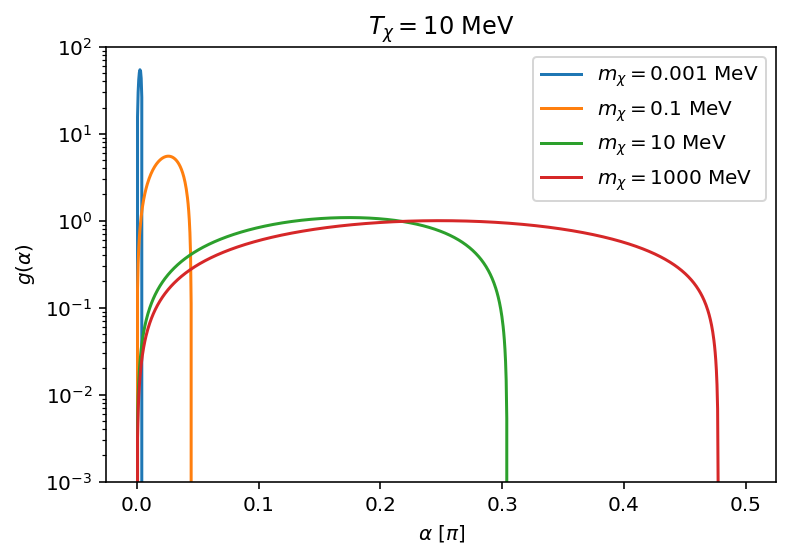

In [87]:
plt.plot(alpha_ls,g1,label='$m_\chi=$'+str(mx1)+' MeV')
plt.plot(alpha_ls,g2,label='$m_\chi=$'+str(mx2)+' MeV')
plt.plot(alpha_ls,g3,label='$m_\chi=$'+str(mx3)+' MeV')
plt.plot(alpha_ls,g4,label='$m_\chi=$'+str(mx4)+' MeV')
#plt.plot(alpha_ls,g5,label='$m_\chi=$'+str(mx5)+' MeV')
plt.legend(loc='best')
plt.xlabel(r'$\alpha~[\pi]$')
plt.ylabel(r'$g(\alpha)$')
plt.title('$T_\chi =$'+str(Tx)+' MeV')
plt.yscale('log')
plt.ylim(1e-3,100)
plt.savefig('g.pdf',facecolor='white',bbox_inches='tight')

## Boosted DM flux at Earth

The upscattered DM flux is given by
$$
\frac{d\Phi^{N}(T_{\chi},t)}{dT_{\chi}dt}=2\pi \mathcal{J}\tau\int_{\cos\theta_{{\rm min}}}^{\cos\theta_{{\rm max}}}d\cos\theta \left. j_{\chi}^{N}(r,T_{\chi},\alpha)\right|_{\frac{r}{c}+\frac{\ell}{v_{\chi}}=t}
$$
where $\theta \in [0,\pi/2]$ and $\mathcal{J}$ is a Jacobian.
Once $t$ is given, the corresponding $r$ is also known for specified $\ell$ and $\cos\theta$ where
$$
r=\sqrt{\ell^2+R^2-2\ell R \cos\theta}
$$
hence after solving
$$
\frac{r}{c}+\frac{\ell}{v_\chi}=t
$$
we have (I used *Mathematica*)
$$
\ell = \frac{-\sqrt{c^{2}v_{\chi}^{2}(R^{2}-2Rtv_{\chi}\cos\theta+t^{2}v_{\chi}^{2})-R^{2}v_{\chi}^{4}\sin^{2}\theta}+c^{2}tv_{\chi}-Rv_{\chi}^{2}\cos\theta}{c^{2}-v_{\chi}^{2}}.
$$
Note that $t$ consists of two parts. The first counts from the propagation time of SN neutrino from the explosion site to the upscattering point $r/c$ (assuming neutrino carries light speed). The second indicates the DM propagation time from the upscattering point to the Earth $\ell/v_\chi$.
In addition, the Jacobian factor is derived as
$$
d\left(\frac{r}{c}+\frac{\ell}{v_\chi}\right)=dt\to \left(\frac{\ell- R\cos\theta}{rc} +\frac{1}{v_\chi}\right)d\ell = dt,
$$
Thus,
$$
\mathcal{J}=\left(\frac{\ell- R\cos\theta}{rc} +\frac{1}{v_\chi}\right)^{-1}.
$$

Some input, such as $t$, have no physical solutions for both $\ell$ and $r$ (one or both of them would be negative). Therefore the contribution from such $t$ to the emissivity $j_\chi^N$ should be removed manually.

Another trouble happens when we use $\sin\alpha =R\sin\theta/r$ to obtain $\alpha$. The two cases are degenerate $\sin\alpha = \sin(\pi-\alpha)$. *Numpy* function `arcsin` only returns $\alpha<\pi/2$ result, despite sometimes the true $\alpha$ is larger than $\pi/2$. So instead of using the law of sine, I implemented the law of cosine which will return the true $\alpha$ even it is larger than $\pi/2$. 

Since $\ell$ and $r$ are known, we have
$$
\cos(\pi-\alpha)=\frac{r^2+\ell^2-R^2}{2r\ell}
$$
thus
$$
\alpha =\cos^{-1}\left(\frac{R^2-r^2-\ell^2}{2r\ell}\right).
$$
The above guarantees the true $\alpha$ can be faithfully revealed.

<div align="center"> <img src="./geometry.png"> </div>

### Simplified expression for $\ell$

We can have more simplified expression for $\ell$ with
$$
r + \frac{\ell}{v_\chi} = ct = c\left(\frac{R}{c}+t_{\rm input}\right) \equiv\zeta
$$
where $r$, $\ell$ and $\zeta$ are in normal length unit and $v_\chi$ the dimensionless velocity. Thus,
$$
\ell = v_{\chi}\times\frac{\zeta-Rv_{\chi}\cos\theta-\sqrt{R^{2}-R^{2}v_{\chi}^{2}+v_{\chi}^{2}\zeta^{2}+R_{\chi}v_{\chi}\cos\theta(Rv_{\chi}\cos\theta-2\zeta)}}{1-v_{\chi}^{2}}.
$$
Note that $t$ is the total propagation time timing from the upscattering point.

### Vanishing BDM at time $t$
For a given $T_\chi$ and $m_\chi$, the vanishing of BDM flux vs. time $t$ corresponds to $g(\alpha)$ is too small to be relevant.
In principle $g(\alpha)$ vanishes when $\alpha=\pi/2$. But as one calculates, $g(\alpha)$ becomes too small to be detected even when $\alpha\ll\pi/2$ in the relativistic case.
Thus, we define an effective angle $\alpha_m$ that indicates $g(\alpha_m)$ touches the zero place (note that in such range $\alpha_m<\alpha<\pi/2$, $g(\alpha)$ is always $0$).
Thus following the law of sine,
$$
\frac{\ell}{\sin\Theta}=\frac{R}{\sin(\pi-\alpha_m)}=\frac{r}{\sin\theta}\to \frac{\ell}{\sin(\alpha_m-\theta)}=\frac{R}{\sin\alpha_m}=\frac{r}{\sin\theta}
$$
we express $\ell=R\sin(\alpha_m-\theta)/\sin\alpha_m$ and $r=R\sin\theta/\sin\alpha_m$. Hence,
$$
t=\frac{r}{c}+\frac{\ell}{v_\chi}=\frac{R}{\sin\alpha_m}\left(\frac{\sin\theta}{c}+\frac{\sin(\alpha_m-\theta)}{v_\chi}\right)
$$
and the maxima of $t$ happens when $\left. dt/d\theta\right|_{\theta=\theta_m}=0$. Generally, $\theta_m$ can be found numerically by solving the following identity,
$$
\frac{\cos(\alpha_m-\theta)}{\cos\theta}=\frac{v_\chi}{c}.
$$
Note that $\theta \in [0,\pi/2]$.

### Finding the $\theta_{\rm max}$ in the integral of $d\Phi_\chi/dT_\chi$

One can simply realize that for a given propagation time $t_{\rm \chi}$, the following identity holds
$$
t_\chi=\frac{r}{c}+\frac{\ell}{v_\chi}=\frac{R}{\sin\alpha}\left(\frac{\sin\theta}{c}+\frac{\sin(\alpha-\theta)}{v_\chi}\right).
$$
Therefore there are infinite solutions $(\alpha,\theta)$ that satisfy the above equation. Because we are solving a problem that has two unknown variables but only one constraint $t_\chi$.
The above equation has a tendency that when we increase $\alpha$, the associated $\theta$ corresponds to $t_\chi=0$ becomes larger.
Since we know that $\alpha$ exceeds $\alpha_m$ has no contribution, we can set the $\theta_m$ resulted from $\alpha_m$ from a given $t_\chi$ is the upper bound of the $\theta$-integral of $d\Phi_\chi/dT_\chi$.

In [256]:
def find_am(Tx,mx,th=1e-10,max_a=0.5*np.pi,show_info=False):
    """
    Find the first alpha that touches g(alpha) ~ 0 when 0 < alpha < pi/2
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    th: threshold
    max_a: upper bound for the range of alpha that the algorithm to search, default is pi/2
    show_info: show message of the root algorithm
    
    Output
    ------
    show_info True: show all message
    show_info False: show the a_min only, in rad
    """
    bracket = [0,max_a]
    min_g = lambda alpha: g(Ev(Tx,mx,alpha),mx,alpha) - th
    a_m = root_scalar(min_g,bracket=bracket,method='brentq')
    if show_info:
        return a_m
    else:
        return a_m.root


def find_tmax(Tx,mx,th=1e-10,max_a=0.5*np.pi,R=8.5):
    """
    Find the vanishing time of the BDM flux for a given Tx and mx
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    th: threshold
    max_a: upper bound for the range of alpha that the algorithm to search, default is pi/2
    R: distance between the SN site and the Earth
    
    Output
    ------
    time: the vanishing time in second after the arrival of the first SN neutrino, in seconds
    """
    t0 = R*kpc2cm/c
    vdm = vx(Tx,mx)
    # am that leads to g(am)=0
    a_m = find_am(Tx,mx,th,max_a,False)
    # define the dt/dtheta = 0
    dtdth = lambda theta: np.cos(a_m - theta)/np.cos(theta) - vdm
    # finding theta_m that leads to dt/dtheta=0
    th_m = root_scalar(dtdth,bracket=[0, 0.5*np.pi],method='brentq').root
    t_max = ((np.sin(th_m) + np.sin(a_m - th_m)/vdm)/np.sin(a_m) - 1)*t0
    return t_max


def find_theta_bound(t,Tx,mx,th=1e-10,max_a=0.5*np.pi,R=8.5):
    """
    Finding the integral bound for theta for given Tx, mx and arrival time
    
    Input
    ------
    t: the arrival time of BDM, origin is set to be the arrival of the first SN neutrino
        note that the input should not exceed the vanishing time lest error will occur
    Tx: DM kinetic energy
    mx: DM mass
    th: threshold
    max_a: upper bound for the range of alpha that the algorithm to search, default is pi/2
    R: distance between the SN site and the Earth
    
    Output
    ------
    tuple: lower and upper bound for theta in the integration, in rad
    """
    vdm = vx(Tx,mx)
    t0 = R*kpc2cm/c
    # find a_min
    a_m = find_am(Tx,mx,th,max_a,False)
    
    # We will use Newton-Raphson method to find the root that corresponds to theta_max
    # This method requires the target function _f and its derivative _fp
    def _f(theta):
        return np.sin(theta) + np.sin(a_m - theta)/vdm - (t/t0 + 1)*np.sin(a_m)
    
    def _fp(theta):
        return np.cos(theta) - np.cos(a_m - theta)/vdm
    
    # find solution to theta_max using Newton-Raphson method
    sol_theta_max = root_scalar(_f,method='newton',x0=np.pi/2,fprime=_fp)    
    if sol_theta_max.converged and 0 <= sol_theta_max.root <= np.pi/2:
        theta_M = sol_theta_max.root
    else:
        #theta_M= sol_theta_max
        raise ValueError('Either input time exceeds vanishing time or something went wrong.')
        
    # find solution to theta_min using Newton-Raphson method
    sol_theta_min = root_scalar(_f,method='newton',x0=0,fprime=_fp)    
    if sol_theta_min.converged and 0 <= sol_theta_min.root <= theta_M:
        theta_m = sol_theta_min.root
    else:
        theta_m = 0
        
    return theta_m,theta_M

In [177]:
def find_lra(t,theta,vx,R=8.5,r_cut=1e-5):
    """
    Find l, r and alpha when t, cos\theta, R and vx are given
    
    Input
    ------
    t: timing in seconds, 0 starts from the first arrival of the SN neutrino at Earth
        theta: in rad
    vx: dimensionless DM velocity, v/c
    R: R in kpc, default 8.5 kpc
    r_cut: the inner most galactic region should be considered, default is 1e-5 kpc
    
    Output
    ------
    tuple: (l,r,alpha,adopt)
           adopt is either True or False that indicates the results should be adopted
           or not
    """
    cos = np.cos(theta)
    R = R*kpc2cm
    zeta = c*t + R
    
    # evaluate l
    numerator = zeta-R*vx*cos-np.sqrt(R**2-(R*vx)**2+(vx*zeta)**2+R*vx*cos*(R*vx*cos-2*zeta))
    denominator = 1-vx**2
    l = vx*numerator/denominator
    # evaluate r
    r = np.sqrt(l**2+R**2-2*l*R*cos)
    # evaluate the param in arccos
    param = (R**2-r**2-l**2)/(2*r*l)
    # checking if param is valid in arccos
    if -1 <= param <= 1:
        alpha = np.arccos(param)
        # checking if the evaluated values satisfied all the requirements
        if l > 0 and r>r_cut*kpc2cm and 0 <= alpha <= np.pi/2:
            return l,r,alpha,True
        else:
            # one or more of the evaluated values is (not) satisfied
            return 0,0,0,False
    else:
        # param is not valid
        return 0,0,0,False

    
def bdmflux(t,theta,Tx,mx,tau=10,sigxv=1e-45,rho=184,rs=24.42,Lv=Lv,R=8.5,r_cut=1e-5):
    """
    Boosted DM flux at Earth, per cm^2 per second
    
    Input
    ------
    t: time in second, 0 starts from the arrival of SN neutrino
    theta: the open angle theta
    Tx: DM kinetic energy, in MeV
    mx: DM mass, in MeV
    tau: the duration of SN explosion, default 10 s
    sigxv: DM-neutrino scattering cross section, default 1e-45 cm^2
    rho: NFW halo profile characteristic density, default 184 MeV/cm^3
    rs: NFW halo profile characteristic length, default 24.42 kpc
    Lv: SN neutrino luminosity, default 1e52 erg/s
    R: distance between Sun and GC, default 8.5 kpc
    r_cut: the inner most galactic region should be considered, default is 1e-5 kpc
    
    Output
    ------
    BDM flux: in the unit of per cm^2 per second for a given t
    """
    # Dimensionless DM velocity
    vdm = vx(Tx,mx)
    # Get l,r,alpha,adopt
    l,r,alpha,adopt = find_lra(t,theta,vdm,R,r_cut)
    if adopt:
        J = c/((l - R*kpc2cm*np.cos(theta))/r + 1/vdm)
        return J*sigxv*xemissivity(Tx,mx,alpha,r,rho,rs,tau,Lv)*np.sin(theta)*vdm
    else:
        return 0

In [254]:
mx = 0.001
Tx = 10
theta_slice= 10
time_ls = np.logspace(3,np.log10(find_tmax(Tx,mx)),100)

bdm_ls_quad = []
for t in time_ls:
    # find the lower and upper bounds for the theta in BDM integration
    theta_m,theta_M =find_theta_bound(t,Tx,mx)
    # slicing the bound into multiple equal parts
    delta = (theta_M-theta_m)/10**theta_slice
    int_val = quad(lambda theta: bdmflux(t,theta,Tx,mx),theta_m,theta_m+10*delta)[0]
    for i in range(1,theta_slice):
        int_val += quad(lambda theta: bdmflux(t,theta,Tx,mx),theta_m+10**i*delta,theta_m+10**(i+1)*delta)[0]
    bdm_ls_quad.append(int_val)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


Text(0, 0.5, 'BDM flux')

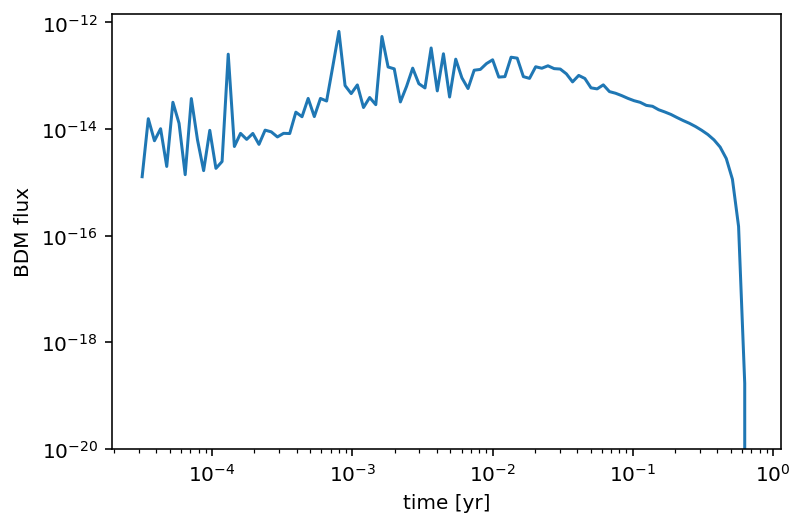

In [255]:
plt.plot(time_ls/yr,bdm_ls_quad)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-20,)
plt.xlabel('time [yr]')
plt.ylabel('BDM flux')

In [244]:
find_tmax(10,0.1)/yr

69.26922305599271

In [257]:
find_theta_bound(70*yr,10,0.1)

ValueError: Either input time exceeds vanishing time or something went wrong.

In [184]:
mx = 1
Tx = 10
time_ls = np.logspace(np.log10(yr)-3,np.log10(find_tmax(Tx,mx)),50)

bdm_ls = []
for t in time_ls:
    theta_integ = vegas.Integrator([[0, find_theta_bound(t,Tx,mx)]])
    int_result = theta_integ(lambda theta: bdmflux(t,theta,Tx,mx), nitn=10, neval=5000)
    try:
        bdm_ls.append(int_result[0].mean)
    except:
        bdm_ls.append(int_result.mean)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in true_divide


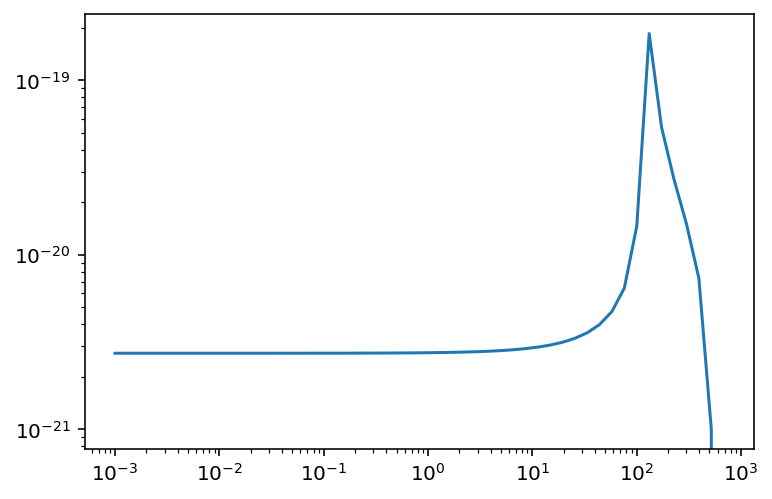

In [186]:
plt.plot(time_ls/yr,bdm_ls)
plt.xscale('log')
plt.yscale('log')

In [179]:
len(bdm_ls)

50

In [142]:
test=theta_integ(lambda theta: bdmflux(1e-2*yr,theta,Tx,mx), nitn=10, neval=2000)

In [147]:
test[0]

9.4892(11)e-17

In [262]:
tmax/yr

6.9347034325825225

In [226]:
def tt(Tx,mx,th,am):
    R = 8.5*kpc2cm
    vdm = vx(Tx,mx)*c
    return R*(np.sin(th)/np.sin(am))/c+R*(np.sin(am-th)/np.sin(am))/vdm -R/c

In [233]:
th_ls = np.logspace(-5,np.log10(0.5*np.pi),100)
Tx= 10
mx = 0.1
amin = find_am(Tx,mx)
tt_ls = []
tt_ls2 = []
tt_ls3 = []
for th in th_ls:
    tt_ls.append(tt(Tx,mx,th,amin)/yr)
    tt_ls2.append(tt(Tx,mx,th,amin/2)/yr)
    tt_ls3.append(tt(Tx,mx,th,amin/10)/yr)

Text(0, 0.5, 'arrival time [yr]')

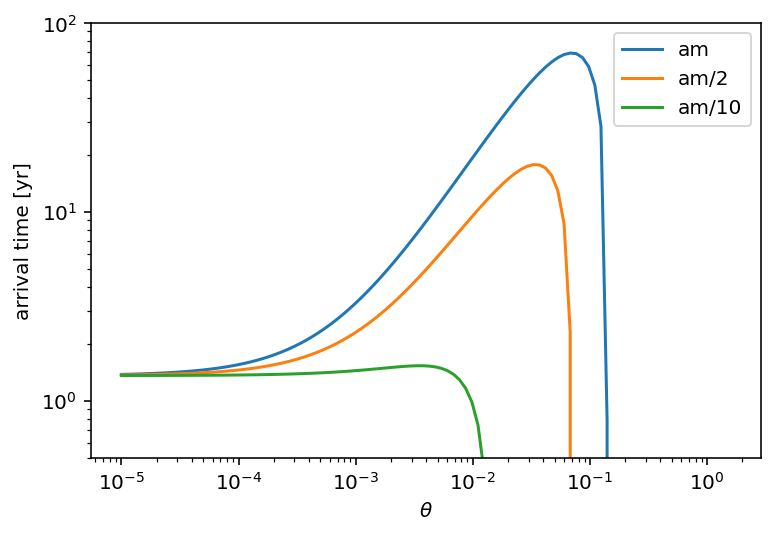

In [243]:
plt.plot(th_ls,tt_ls,label='am')
plt.plot(th_ls,tt_ls2,label='am/2')
plt.plot(th_ls,tt_ls3,label='am/10')
#plt.plot([[1e-5,0.5*np.pi]],[[8,8]],'--')
plt.xlabel(r'$\theta$')
plt.legend()
plt.xscale('log')
plt.ylim(0.5,100)
plt.yscale('log')
plt.xlabel(r'$\theta$')
plt.ylabel('arrival time [yr]')

In [10]:
find_theta_bound(10,0.1,0)

0.14048970175302428

In [16]:
tt(10,0.1,0.14048970175302,amin)

0.0001220703125

In [135]:
root_scalar(lambda th: np.cos(amin-th)/np.cos(th)-vx(10,0.1),bracket=[0, 0.5*np.pi],method='brentq')

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.06989652246922248

In [151]:
th_ls[np.argmax(tt_ls)]

0.022250241724347083

In [152]:
np.max(tt_ls)

69.26922275226967

In [156]:
8.5*kpc2cm*(1/vx(10,0.1)/c-1/c)/yr

1.3598823884477358

In [152]:
# All in MeV
mx1 = 0.001
mx2 = 0.01
mx3 = 0.01
mx4 = 1
mx5 = 10
Tx = 10
# define integral range for theta
theta_integ = vegas.Integrator([[0, 0.5*np.pi]])

# years
yrls=np.int64(np.logspace(-3,1.3,70)*yr)
#yrls = np.append(yrls1,yrls2)
tot_job = len(yrls)
job = 1
#fluxmx1_single=[]
#for y in yrls:
#    fluxmx1_single.append(bdmflux_single(y*yr,Tx,mx1))

#fluxmx2_single=[]
#for y in yrls:
#    fluxmx2_single.append(bdmflux_single(y*yr,Tx,mx2))
    
fluxmx3_single=[]
for y in yrls:
    fluxmx3 = theta_integ(lambda theta: bdmflux(y,theta,Tx,mx3), nitn=10, neval=5000)
    try:
        fluxmx3_single.append(fluxmx3[0].mean)
    except:
        fluxmx3_single.append(fluxmx3.mean)
    print('Total '+str(job)+' out of '+str(tot_job)+' jobs are complete!',end="\r")
    job+=1
    

#fluxmx4_single=[]
#for y in yrls:
#    fluxmx4_single.append(bdmflux_single(y*yr,Tx,mx4))


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until


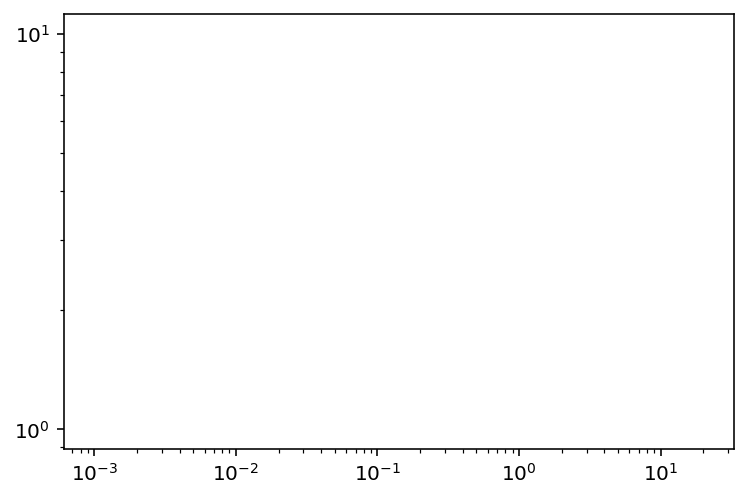

In [153]:
plt.plot(yrls/yr,fluxmx3_single)
plt.xscale('log')
plt.yscale('log')

In [202]:
theta_integ = vegas.Integrator([[0, 1e-7]])

In [217]:
theta_integ(lambda theta: bdmflux(1e3,theta,Tx,mx3), nitn=20, neval=10000)

0.0(7.1)e-130

In [216]:
bdmflux(0.01*yr,1e-7,Tx,mx3)

0

In [140]:
for i in range (10):  
    print(i, end="\r")

In [127]:
theta_integ(lambda x: bdmflux(yrls[3],x[0],x[1],mx3), nitn=20, neval=10000)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


1.718(14)e-21

In [128]:
theta_integ(lambda x: bdmflux(yrls[3],x[0],x[1],mx3), nitn=20, neval=10000)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


1.7190(10)e-21

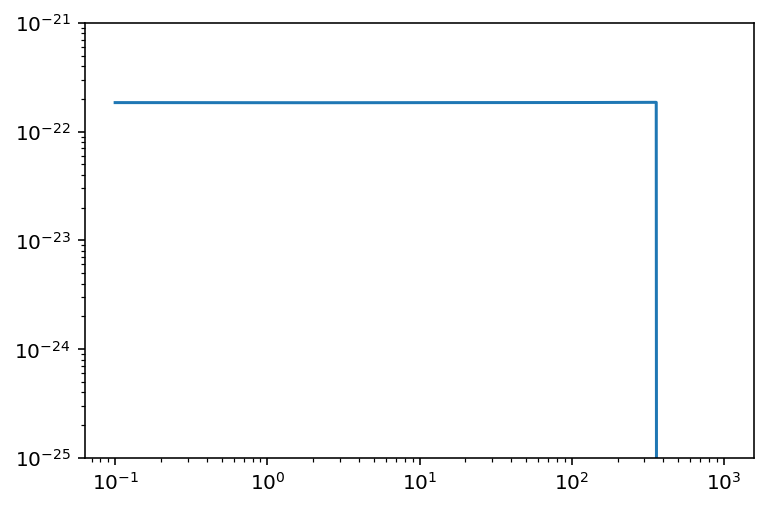

In [131]:
plt.plot(yrls/yr,fluxmx3_single)
plt.ylim(1e-25,1e-21)
plt.xscale('log')
plt.yscale('log')

In [211]:
try:
    np.arccos(-1.1)
    print('try success')
except:
    print('try failed')

try success


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arccos
  


In [41]:
fluxmx3

RAvgArray([1.844731(36)e-22], dtype=object)

In [12]:
test_ls=[]
for y in yrls:
    test_ls.append(y)

In [79]:
flux = theta_integ(lambda theta: bdmflux(5*yr,theta,10,0.01),nitn=10, neval=10000)
flux

0.0(1.0)e-129

In [13]:
test_ls

[315, 9972, 315360, 9972558, 315360000]

In [81]:
yrls=np.logspace(-5,1,20)*yr

In [85]:
np.int64(yrls)

array([      315,       652,      1350,      2793,      5780,     11960,
           24748,     51207,    105955,    219236,    453629,    938622,
         1942138,   4018553,   8314942,  17204763,  35599031,  73659312,
       152411288, 315360000])

In [32]:
bdmflux(10,0.001,5,10)

9.70551059854033e-25

In [41]:
find_lra(100,0.01,vx(5,0.5))

(8.584364222582893, 0.1200581977021025, 2.354961396943058, False)

In [9]:
test_lra=find_lra(100,0.01,vx(5,0.5))

In [16]:
(np.float64(test_lra[0:3])/kpc2cm)[0]

8.584364222591969

In [42]:
def f(x):
    return x

In [43]:
f([1,2])

[1, 2]

In [47]:
integ = vegas.Integrator([[0, 1]])


In [48]:
result=integ(f, nitn=10, neval=1000)
result

RAvgArray([0.499949(33)], dtype=object)

In [58]:
result[0].mean

0.49994881472893116

Text(0, 0.5, 'y (cm)')

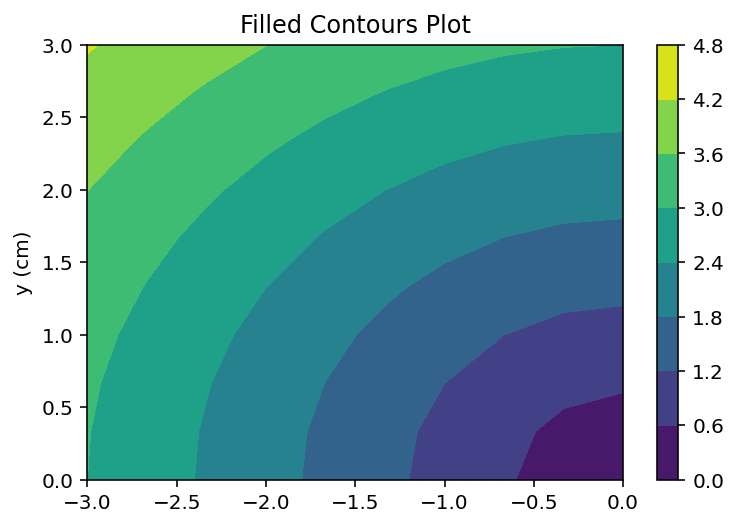

In [18]:
xlist = np.linspace(-3.0, 0, 10)
ylist = np.linspace(0, 3.0, 10)
X, Y = np.meshgrid(xlist, ylist)
Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')

In [12]:
(8.5*kpc2cm/vx(50,0.001)/c-8.5*kpc2cm/c)/yr

5.534194799197742e-06

In [11]:
vx?

Signature: vx(Tx, mx)
Docstring:
The dimensionless DM velocity. To restore the physical unit, just
times the speed of light c

Input
------
Tx: DM kinetic energy
mx: DM mass

Output
------
vx: dimensionless DM velocity
File:      ~/SNvBDM/<ipython-input-4-bf4762ff563f>
Type:      function


In [23]:
testz(xlist[3],ylist[6])

2.8284271247461903

In [50]:
dtest = grad(test)

In [51]:
print(dtest(2.0,3.0))

109.196304


In [36]:
def tanh(x):  # Define a function
    y = jnp.exp(2.0 * x)
    return y#(1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)  # Obtain its gradient function
print(grad_tanh(1.0))

14.778112


In [71]:
np.float32([5,6,7])

array([5., 6., 7.], dtype=float32)

In [78]:
1e20-(1e20+1)

0.0

In [79]:
(1e20-1e20)+1

1.0